In [1]:
%pip install datasets nltk
%pip install torchtext==0.17.0
%pip install -U portalocker>=2.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64",

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1.Data preparation 

In [3]:
from datasets import load_dataset

imdb = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
train_data, test_data = imdb['train'], imdb['test']

In [6]:
#import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
vocab_size = 20000

def yield_tokens(data_iter):
    for data in data_iter:
        yield tokenizer(data["text"])

vocab = build_vocab_from_iterator(yield_tokens(train_data),
                                min_freq=3,
                                max_tokens=vocab_size,
                                specials=["<pad>", "<s>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [27]:
seq_length = 200
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch, seq_length=seq_length):
    text_list, label_list = [], []
    for sample in batch:
        label_list.append(sample['label'])

        text_processed = text_pipeline(sample['text'])[:seq_length]
        if len(text_processed) < seq_length:
            pad_size = seq_length - len(text_processed) -1
            text_processed = [vocab["<pad>"]] * pad_size + [vocab["<s>"]] + text_processed
        text_list.append(text_processed)

    input_ids = torch.tensor(text_list, dtype=torch.int64)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return (input_ids, labels)

In [28]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True)

# Model

In [33]:
class MyMultiheadAttention(nn.Module):
    def __init__(self, embed_dim):
        super(MyMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim

    def forward(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.embed_dim ** 0.5)
        attention_output = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_output, value)

        return output

class TransformerTextCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, dropout, device):
        super().__init__()
        self.word_emb = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim)
        self.attn = MyMultiheadAttention(embed_dim=embed_dim)
        self.fc = nn.Linear(in_features=200*32, out_features = 2)

    def forward(self, x):
        output = self.word_emb(x)
        query, key, value = output, output, output
        attn_output = self.attn(query, key, value)
        output = nn.Flatten()(attn_output)
        output = self.fc(output)
        return output

In [34]:
max_length = seq_length #200
embed_dim = 32
ff_dim = 32
dropout = 0.1
model = TransformerTextCls(vocab_size, max_length, embed_dim, dropout, device)

# Evaluation

In [35]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = correct * 100 / total

    return test_loss, accuracy

# Train

In [38]:
max_epochs = 20
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)

for epoch in range(max_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels, in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * running_correct / total
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 0.5275, Accuracy: 76.80%, Test Loss: 0.6315, Test Accuracy: 73.81%
Epoch [2/20], Loss: 0.3522, Accuracy: 85.70%, Test Loss: 0.6322, Test Accuracy: 75.47%
Epoch [3/20], Loss: 0.2428, Accuracy: 90.38%, Test Loss: 0.6664, Test Accuracy: 76.67%
Epoch [4/20], Loss: 0.1646, Accuracy: 93.99%, Test Loss: 0.7204, Test Accuracy: 77.29%
Epoch [5/20], Loss: 0.1097, Accuracy: 96.33%, Test Loss: 0.7928, Test Accuracy: 77.44%
Epoch [6/20], Loss: 0.0656, Accuracy: 97.99%, Test Loss: 0.8615, Test Accuracy: 77.37%
Epoch [7/20], Loss: 0.0355, Accuracy: 99.18%, Test Loss: 0.9297, Test Accuracy: 77.54%
Epoch [8/20], Loss: 0.0226, Accuracy: 99.51%, Test Loss: 1.0132, Test Accuracy: 77.99%
Epoch [9/20], Loss: 0.0147, Accuracy: 99.71%, Test Loss: 1.0503, Test Accuracy: 78.38%
Epoch [10/20], Loss: 0.0073, Accuracy: 99.92%, Test Loss: 1.1046, Test Accuracy: 78.37%
Epoch [11/20], Loss: 0.0046, Accuracy: 99.92%, Test Loss: 1.1449, Test Accuracy: 78.86%
Epoch [12/20], Loss: 0.0025, Accuracy: 10

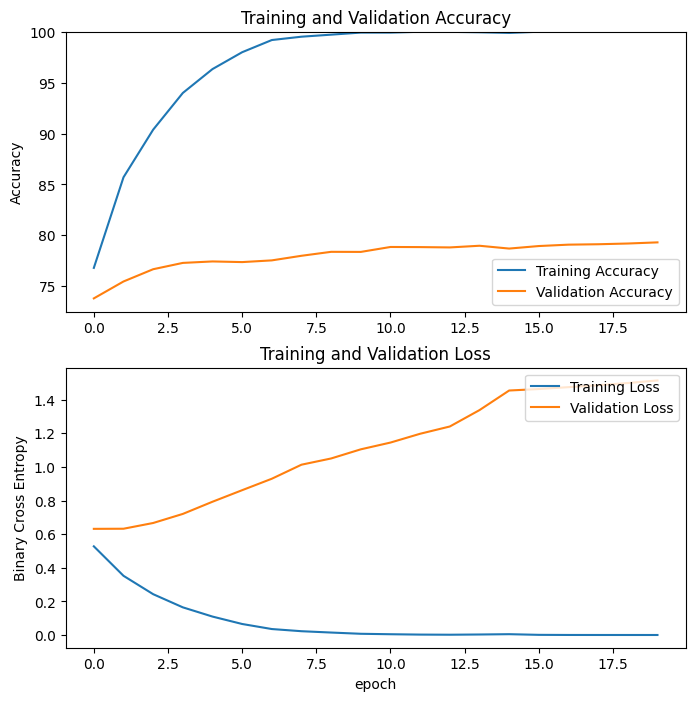

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()